# Lecture 7 — Machine Learning II, Regression: Neural Networks

## Learning Outcomes
- Understand neural networks as flexible nonlinear regression models.
- Learn the basic history and motivation of neural networks.
- Define a neural network mathematically (equations, structure).
- Recognize common terminology (layers, neurons, activation, loss, training).
- Implement regression neural networks using `scikit-learn`.
- Recognize the importance of scaling, validation, and hyperparameters.

## Motivation and History
- In chemical engineering, we often face nonlinear models (reaction kinetics, transport, thermodynamics).
- Linear regression and polynomial regression are limited in flexibility.
- Neural networks (NNs) emerged in the 1940s–50s inspired by biological neurons, revived in the 1980s, and became dominant in the 2010s with deep learning applications.
- Today: we use NNs as *[universal function approximators](https://en.wikipedia.org/wiki/Universal_approximation_theorem)*.

**Note:** Just as we expanded features with polynomials, NNs expand the feature space adaptively by *learning nonlinear transformations*.

**Interesting fact: The 2024 Nobel Prize winner in Physics was prof. Geoffrey Hinton, former CMU Faculty, for his work on Neural Networks! Details [here.](https://www.cmu.edu/news/stories/archives/2024/october/former-cmu-faculty-geoffrey-hinton-awarded-2024-nobel-prize-in-physics)**

## A Flexible Nonlinear Regression Random Function...
We'll model a noisy nonlinear function. Let the data be defined by this true function:


$$ y = x^{1/3} + \epsilon, \qquad \epsilon \sim \mathcal{N}(0, \sigma^2) $$


We'll try the following functional form with **three nonlinear units**:


$$ f(x;\,\theta) = b_1 + w_{10}\,\tanh(w_{00}x+b_{00}) + w_{11}\,\tanh(w_{01}x+b_{01}) + w_{12}\,\tanh(w_{02}x+b_{02}). $$


We will fit parameters $\theta=\{b_1, w_{10}, w_{00}, b_{00}, w_{11}, w_{01}, b_{01}, w_{12}, w_{02}, b_{02}\}$ by **curve fitting/optimization**. Let's also split this into training/test sets. Let's pick 80/20.

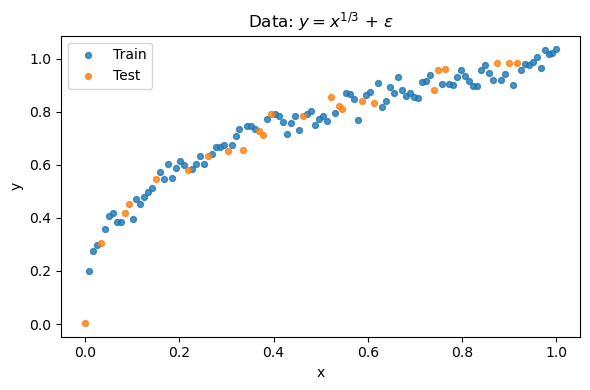

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Generating some data with pseudorandom noise.
rng = np.random.default_rng(0)

X = np.linspace(0, 1, 120)
X = X.reshape(-1, 1)
y = X**(1/3) + rng.normal(0, 0.03, size=X.shape)

# y = X**(1/3) + np.random.normal(0, 0.03, size=X.shape)



# Splitting into train/test.
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)


# Plot.
plt.figure(figsize=(6,4))
plt.scatter(Xtr, ytr, s=18, label='Train', alpha=0.8)
plt.scatter(Xte, yte, s=18, label='Test', alpha=0.8)
plt.xlabel('x')
plt.ylabel('y') 
plt.legend() 
plt.title('Data: $y=x^{1/3}$ + $\\epsilon$')
plt.tight_layout()
plt.show()

Let's now define this nonlinear function.

In [54]:
def model(x, *params):

    # Unpack the parameters
    b1, w10, w00, b00, w11, w01, b01, w12, w02, b02 = params

    # Make the prediction
    y = (
        b1
        + w10 * np.tanh(w00 * x + b00)
        + w11 * np.tanh(w01 * x + b01)
        + w12 * np.tanh(w02 * x + b02)
    )
    return y

And let's optimize this using scipy.optimize.minimize, as we seen in class before:

In [ ]:
from scipy.optimize import minimize

# Sum squared error loss function! No regularization yet.
def loss(parameters, X, y):
    """
    Loss function that takes parameters, features X and target y.

    Inputs
    ------
    parameters:  list
        List of our parameters.
    X: float
        Our inputs.
    y: float
        Our outputs.
    
    Returns
    -------
    Loss: scalar
        SSE (Loss function)
    
    """

    # We evaluate the model...
    y_pred = model(X, *parameters)

    # And calculate the loss: The SSE between model predictions and experimental data.
    loss = sum((y - y_pred) ** 2)
    return loss


# Least squares regression fit using scipy.optimize.minimize
sol = minimize(
    loss,
    np.random.normal(size=(10,)),
    args=(Xtr, ytr), tol=1e-5
)
print('Parameters:')
print(sol.x)
print('SSE (Loss) is:')
print(sol.fun)

Parameters:
[-2.04764865e+01 -2.93187989e+00 -1.99903018e-01  1.04774138e+00
  2.38175130e-02  4.05887209e+01 -3.89174787e+01 -2.35101611e+01
 -2.50102138e+00 -2.27956037e+00]
SSE (Loss) is:
0.07528606740863546


Let's see how this model performs regarding extrapolation.

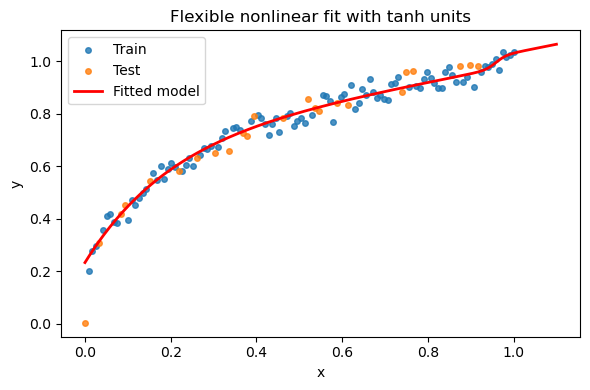

Test R-square: 0.9450583731565009


In [56]:
xx = np.linspace(0, 1.1, 400)
yhat = model(xx, *sol.x)

plt.figure(figsize=(6,4))
plt.scatter(Xtr[:,0], ytr, s=16, label='Train', alpha=0.8)
plt.scatter(Xte[:,0], yte, s=16, label='Test', alpha=0.8)
plt.plot(xx, yhat, 'r-', lw=2, label='Fitted model')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Flexible nonlinear fit with tanh units')
plt.legend(); plt.tight_layout(); plt.show()

from sklearn.metrics import r2_score
yhat_te = model(Xte[:,0], *sol.x)
print('Test R-square:', r2_score(yte, yhat_te))

## A Particular and Interesting Structure

So far, what we have really done is a nonlinear regression, just with an unusual-looking functional form. The important point is that this model is **flexible**: it can fit a wide variety of nonlinear shapes, not just a single equation. We can have this model with different nonlinear functions (rather than tanh) and different numbers of parameters.

But this model did not come out of nowhere. Let’s rewrite it step by step to see the underlying structure.

If we allow the nonlinear function $\tanh$ to act element-wise on a vector, we can write our three-unit model more compactly as:

$$
y =
\begin{bmatrix} w_{10} & w_{11} & w_{12} \end{bmatrix}
\;\; \tanh \!\left(
\begin{bmatrix}
w_{00} \, x + b_{00} \\
w_{01} \, x + b_{01} \\
w_{02} \, x + b_{02}
\end{bmatrix}
\right) + b_1
$$

This can be expressed even more clearly in **matrix notation**:

$$
y = w^{(1)} \, \tanh\!\big(W^{(0)} x + b^{(0)}\big) + b^{(1)}.
$$



### What Does This Mean?

- Start with the input $x$.
- Multiply by a set of **weights** $W^{(0)}$.
- Add a vector of **biases** $b^{(0)}$.
- Apply a nonlinear **activation function** $\tanh(\cdot)$.
- Multiply by a new set of **weights** $w^{(1)}$.
- Add a final **bias** $b^{(1)}$.
- The result is the output $y$.

This construction is exactly what we call a **neural network**:
- an **input layer** ($x$),
- one **hidden layer** with three nonlinear units activated by $\tanh$,
- and an **output layer** with linear activation.





### Why "Neural" Networks?

The terminology comes from biology: neurons take signals from inputs, combine them, and if the signal is strong enough they “fire.” Our activation function (here, $\tanh$) is a smooth, differentiable approximation of that behavior. Although modern networks are far removed from actual brains, the language stuck.  



A key theoretical result: neural networks with at least one hidden layer are **universal function approximators**. In principle, they can represent any continuous function if given enough hidden units.

A conventional schematic representation looks like this:

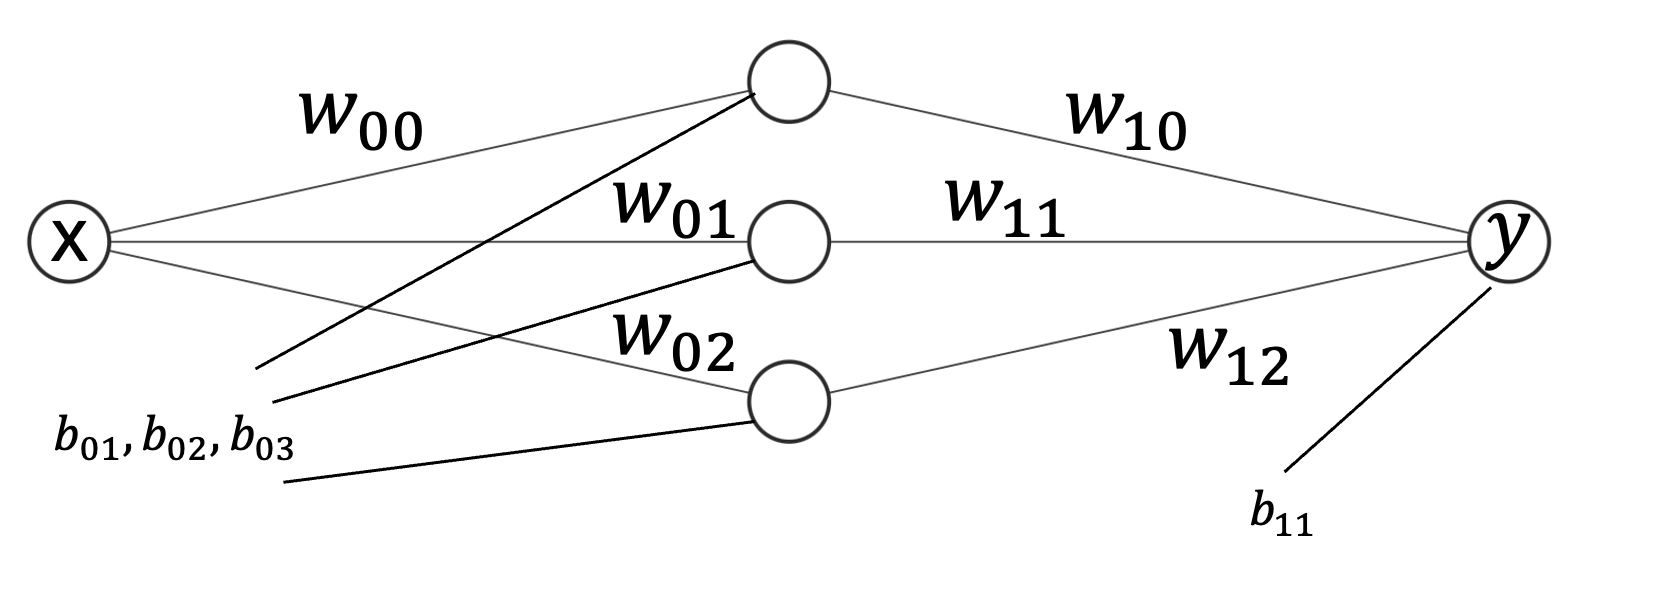

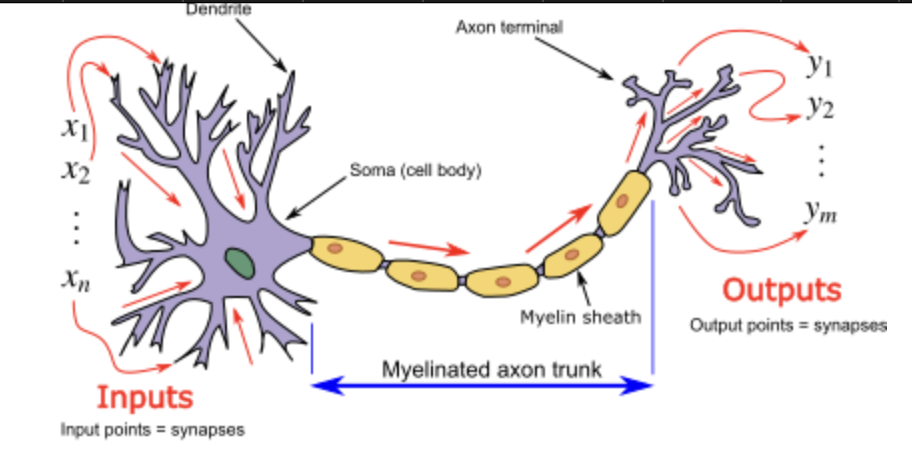

This file is licensed under the [Creative Commons Attribution-Share Alike 3.0 Unported license](https://creativecommons.org/licenses/by-sa/3.0/deed.en).

[Link to image on Wikipedia](https://en.wikipedia.org/wiki/File:Neuron3.png)

### Design Choices = Hyperparameters

When we build a neural network, we make several *structural* choices:

1. **How many layers?** Here we used one hidden layer, but we can stack multiple layers to increase flexibility.
2. **How many neurons per layer?** More neurons = more parameters, increasing capacity to fit complex patterns.
3. **What activation function?** $\tanh$ and sigmoid are classics; ReLU and others are common today.

These choices are called **hyperparameters**: they define the model's size and shape but are not themselves fitted during training. Choosing them is often based on experience, and experimentation. Systematic methods exist (grid search, Bayesian optimization), but can be computationally expensive.


We can now state it directly:

$$
y = w^{(1)}\,\sigma\big(W^{(0)}x + b^{(0)}\big) + b^{(1)},
$$

with $\sigma(z)=\tanh(z)$ applied elementwise.  

With W and b as the weights and biases.

The parameters we just estimated (via optimization) are **exactly** the weights and biases of this one-hidden-layer neural network.

### Core NN Terminology 
- **Neuron**: computes $a = \sigma(w^\top x + b)$.
- **Layer**: a collection of neurons at the same stage.
- **Hidden layer**: nonlinear feature transformation between input and output.
- **Loss**: $\sum_i (y_i - \hat y_i)^2$.
- **Training**: adjusting weights and biases to minimize the loss. Speaking of training... It's nothing but an optimization problem!

## The training of a NN: Merely an optimization Problem

Training a neural network means solving an optimization problem:

$$ \min_{W,b} \sum_{i=1}^N (y_i - f(x_i; W,b))^2 $$

- Objective: minimize squared error.
- Variables: network parameters (weights $w$, biases $b$).
- Method: gradient-based optimization ([LBFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS), [Adam](https://arxiv.org/abs/1412.6980), [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)).
- Challenge: non-convex, multiple local minima, sensitivity to initialization.

**Note 1:** Scikit-learn abstracts optimization away when we do `.fit`, but understanding this helps interpret convergence and warnings.

**Note 2:**  L-BFGS is a variant of Newton's method we have seen in class!

0.9499563854622886
Test R^2 (3 tanh, LBFGS): 0.950


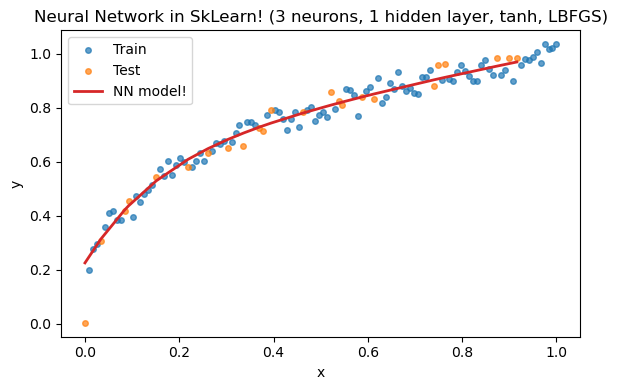

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score


NN = MLPRegressor(
    hidden_layer_sizes=(3,),
    activation='tanh',
    solver='lbfgs',
    alpha=0.0,
    max_iter=5000,
    random_state=0
)

ytr = ytr.ravel()

NN.fit(Xtr, ytr)

# Predictions
ytr_hat = NN.predict(Xtr)
yte_hat = NN.predict(Xte)

# Compute R^2
r2 = r2_score(yte, yte_hat)

# Alternatively:
print(NN.score(Xte, yte))

print(f"Test R^2 (3 tanh, LBFGS): {r2:.3f}")

# Sort test data for plotting, since the sklearn function performs the train/test split "randomly"
order = np.argsort(Xte[:,0])
Xte_sorted = Xte[order]
yte_sorted = yte[order]
yte_hat_sorted = yte_hat[order]

# Plot
plt.figure(figsize=(6,4))
plt.scatter(Xtr[:,0], ytr, s=16, alpha=0.7, label='Train')
plt.scatter(Xte[:,0], yte, s=16, alpha=0.7, label='Test')
plt.plot(Xte_sorted[:,0], yte_hat_sorted, 'C3', lw=2, label='NN model!')
plt.xlabel('x'); 
plt.ylabel('y')
plt.title('Neural Network in SkLearn! (3 neurons, 1 hidden layer, tanh, LBFGS)')
plt.legend(); 
plt.tight_layout(); 
plt.show()

Let's see the weights and biases sklearn calculated:

In [58]:
NN.coefs_

[array([[-0.15543434,  3.69375788,  0.45300008]]),
 array([[0.02963057],
        [1.55766448],
        [1.02107467]])]

In [59]:
NN.intercepts_

[array([0.32198908, 1.00884827, 0.09750721]), array([-1.07496868])]

### Scaling!

Consider a dataset with two features on very different scales:

- $x_1 \in [0,1]$
- $x_2 \in [0, 10^6]$

and a target defined as

$$
y = 0.7 \, \sin\!\big(2\pi x_1\big) \;+\; 0.3 \,\frac{x_2}{10^6}.
$$

Both features matter for predicting $y$, but they are on completely different scales.  
If we train a neural network **without scaling**, the huge values of $x_2$ dominate the learning process, and the optimizer struggles to adjust weights and biases.  

If we **standardize** the features first (zero mean, unit variance), both $x_1$ and $x_2$ are on equal footing, and the network can learn the correct relationship.

R^2 without scaling: -0.00606
R^2 with scaling:    0.99992


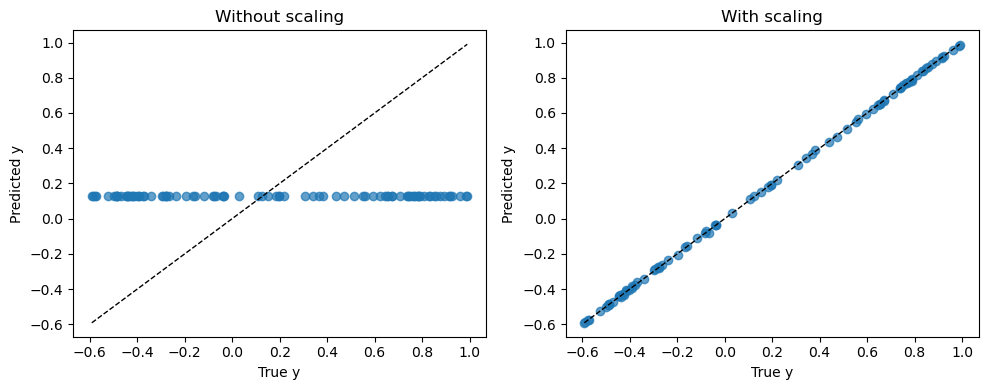

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

#  Data: 2 features, very different scales
# x1 in [0, 1], x2 in [0, 1e6]
np.random.seed(0)
N = 300
x1 = np.random.rand(N, 1)                 # [0,1]
x2 = (1e6 * np.random.rand(N, 1))         # [0, 1e6]
X = np.hstack([x1, x2])

# True function combines a smooth term in x1 and a linear term in x2
y = 0.7 * np.sin(2*np.pi*x1[:,0]) + 0.3 * (x2[:,0] / 1e6)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42)

# Model WITHOUT scaling
mlp_no = MLPRegressor(hidden_layer_sizes=(20,), activation='tanh',
                      solver='lbfgs',
                      max_iter=3000, random_state=0)
mlp_no.fit(Xtr, ytr)
yhat_no = mlp_no.predict(Xte)
r2_no = r2_score(yte, yhat_no)

# Model WITH scaling 
mlp_yes = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(20,), activation='tanh',
                 solver='lbfgs',
                 max_iter=3000, random_state=0)
)

mlp_yes.fit(Xtr, ytr)
yhat_yes = mlp_yes.predict(Xte)
r2_yes = r2_score(yte, yhat_yes)

print(f"R^2 without scaling: {r2_no:.5f}")
print(f"R^2 with scaling:    {r2_yes:.5f}")

#  Plots...
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(yte, yhat_no, alpha=0.7)
lims = [min(yte.min(), yhat_no.min()), max(yte.max(), yhat_no.max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Without scaling")

plt.subplot(1,2,2)
plt.scatter(yte, yhat_yes, alpha=0.7)
lims = [min(yte.min(), yhat_yes.min()), max(yte.max(), yhat_yes.max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("With scaling")

plt.tight_layout()
plt.show()

## Summary

- NN = nonlinear regression (weights + biases + activations)  
- Training = adjust weights/biases to minimize loss
- Hyperparameters: layers, neurons, activation
- Activations (e.g. tanh) give nonlinearity: flexibility
- With enough units: universal approximators
- Sklearn `MLPRegressor` = easy NN tool
- Always **scale inputs** when having training issues (`StandardScaler` in Sklearn)
- Strengths: flexible, powerful, nonlinear 
- Weaknesses: many parameters, sensitive, less interpretable


Most important:

# **Demystify NNs**: they are *just math*, not magic

## References

- [Prof. Kitchin's Data science and machine learning in science and engineering course](https://kitchingroup.cheme.cmu.edu/s24-06642/00-introduction/introduction.html) 
- [Prof. Ulissi's Numerical Methods and ML for ChE Notes](https://ulissigroup.cheme.cmu.edu/F22-06-325/intro.html), [CC-BY 4.0 license](https://creativecommons.org/licenses/by/4.0/legalcode) 

## Other Cool Stuff:

- [NN animations by Harrison Kinsley & Daniel Kukiela](https://nnfs.io/neural_network_animations)
- [3Blue1Brown YouTube's channel, series about Neural Networks: Awesome animations!](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=hPgVrTVNvjU2uQ7i)